In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc,roc_auc_score, roc_curve, classification_report, confusion_matrix,RocCurveDisplay
from imblearn.over_sampling import SMOTE

import joblib
import h5py

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 25)
pd.set_option('display.width', 1000)

In [ ]:
import sklearn
sklearn.__version__

'1.3.2'

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/CDAC_FinalProject/Data/dataset/Kaggle_Training_Dataset_v2.csv',sep=',')
test = pd.read_csv('/content/drive/MyDrive/CDAC_FinalProject/Data/dataset/Kaggle_Test_Dataset_v2.csv',sep=',')

<ipython-input-44-166251ccc04b>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('/content/drive/MyDrive/CDAC_FinalProject/Data/dataset/Kaggle_Training_Dataset_v2.csv',sep=',')
<ipython-input-44-166251ccc04b>:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv('/content/drive/MyDrive/CDAC_FinalProject/Data/dataset/Kaggle_Test_Dataset_v2.csv',sep=',')


In [ ]:
train = train[:-1]
test = test[:-1]

In [ ]:
# concating train and test data.
df=pd.concat([train,test])
print("The final shape of the data is =",df.shape)

The final shape of the data is = (1929935, 23)


In [ ]:
# checking now the nullvalues
percentage1 = df.isnull().sum()
percentage2 = df.isnull().sum()/df.isnull().count()*100
missing_values=pd.concat([percentage1,percentage2], axis=1,keys=['Total','%'])
missing_values

,Total,%
sku,0,0.00000
national_inv,0,0.00000
lead_time,115617,5.99072
in_transit_qty,0,0.00000
forecast_3_month,0,0.00000
forecast_6_month,0,0.00000
forecast_9_month,0,0.00000
sales_1_month,0,0.00000
sales_3_month,0,0.00000
sales_6_month,0,0.00000


In [ ]:
# But as we see above, in some columns it is noted as -99.00 (perf_6_month_avg, perf_12_month_avg)
# Let's see what percentage of data having -99.0 value
l_col = ['perf_6_month_avg','perf_12_month_avg']
(df[ l_col] == -99.0).sum() / df.shape[0]

,0
perf_6_month_avg,0.076987
perf_12_month_avg,0.072554


In [ ]:
a=df.iloc[np.where(df['perf_6_month_avg']==-99.00)[0]].index
b=df.iloc[np.where(df['perf_12_month_avg']==-99.00)[0]].index
print(len(a))
print(len(b))

148579
140025


In [ ]:
df[['perf_6_month_avg','perf_12_month_avg']]= df[['perf_6_month_avg','perf_12_month_avg']].replace(-99.00,np.NaN)

In [ ]:
df[['perf_6_month_avg','perf_12_month_avg']].isnull().sum()

,0
perf_6_month_avg,148579
perf_12_month_avg,140025


In [ ]:
imputer=SimpleImputer(strategy='median')
df[['perf_6_month_avg']]=imputer.fit_transform(df[['perf_6_month_avg']])
df[['perf_12_month_avg']]=imputer.fit_transform(df[['perf_12_month_avg']])

In [ ]:
df[['perf_6_month_avg','perf_12_month_avg']].isnull().sum()

,0
perf_6_month_avg,0
perf_12_month_avg,0


In [ ]:
df.loc[df['lead_time'].isnull(),'lead_time'] = df['lead_time'].median()

In [ ]:
df.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.85,0.83,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.85,0.83,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,No,0.0,0.85,0.83,0.0,Yes,No,No,Yes,No,No


In [ ]:
#dropping sku column
df.drop('sku', axis=1, inplace=True)

In [ ]:
num_col=[]
cat_col=[]
for col in df.select_dtypes(include='float64'):
    num_col.append(col)
for col in df.select_dtypes(exclude='float64'):
    cat_col.append(col)

In [ ]:
print(num_col)
print(' ')
print(f"Number Of Numeric Columns : {len(num_col)}")
print('--------------------------------')
print(cat_col)
print(' ')
print(f"Number Of Categorical Columns : {len(cat_col)}")

['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month', 'forecast_6_month', 'forecast_9_month', 'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank', 'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg', 'local_bo_qty']
 
Number Of Numeric Columns : 15
--------------------------------
['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']
 
Number Of Categorical Columns : 7


In [ ]:
# choosing sample data randomly
sampled_df = df.sample(n=700000, random_state=20)

In [ ]:
sampled_df['went_on_backorder'].value_counts()

,count
went_on_backorder,
No,694902
Yes,5098


In [ ]:
# Top Features to build the Model
top_cols = ['forecast_3_month','national_inv', 'sales_3_month', 'sales_9_month','perf_6_month_avg', 'in_transit_qty','min_bank','lead_time', 'local_bo_qty', 'pieces_past_due','potential_issue','ppap_risk','deck_risk', 'stop_auto_buy','went_on_backorder']

In [ ]:
len(top_cols)

15

In [ ]:
df_final = sampled_df[top_cols]

In [ ]:
df_final

,forecast_3_month,national_inv,sales_3_month,sales_9_month,perf_6_month_avg,in_transit_qty,min_bank,lead_time,local_bo_qty,pieces_past_due,potential_issue,ppap_risk,deck_risk,stop_auto_buy,went_on_backorder
885125,0.0,115.0,33.0,56.0,0.33,0.0,0.0,2.0,0.0,0.0,No,No,Yes,Yes,No
1029593,0.0,328.0,64.0,255.0,0.97,4.0,163.0,8.0,0.0,0.0,No,No,No,Yes,No
590597,0.0,10.0,0.0,0.0,0.58,0.0,1.0,12.0,0.0,0.0,No,No,Yes,Yes,No
1394041,0.0,1.0,0.0,0.0,0.73,0.0,0.0,12.0,0.0,0.0,No,No,Yes,Yes,No
140766,0.0,25.0,1.0,16.0,0.97,0.0,1.0,2.0,0.0,0.0,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654038,300.0,112.0,413.0,463.0,0.93,60.0,44.0,8.0,0.0,0.0,No,No,No,Yes,No
782928,0.0,29.0,0.0,0.0,0.98,0.0,2.0,52.0,0.0,0.0,No,No,Yes,No,No
258152,0.0,290.0,87.0,271.0,0.99,3.0,23.0,9.0,0.0,0.0,No,No,No,Yes,No
20316,0.0,26.0,7.0,8.0,0.99,0.0,2.0,2.0,0.0,0.0,No,Yes,No,Yes,Yes


In [ ]:
# Specify features and target
numerical_features = ['forecast_3_month', 'national_inv', 'sales_3_month', 'sales_9_month', 'perf_6_month_avg',
                       'in_transit_qty', 'min_bank', 'lead_time', 'local_bo_qty', 'pieces_past_due']
categorical_features = ['potential_issue', 'ppap_risk', 'deck_risk', 'stop_auto_buy']
target = 'went_on_backorder'

In [ ]:
# Encode categorical features
label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    df_final[feature] = le.fit_transform(df_final[feature])
    label_encoders[feature] = le

<ipython-input-90-4da90a907094>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[feature] = le.fit_transform(df_final[feature])
<ipython-input-90-4da90a907094>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[feature] = le.fit_transform(df_final[feature])
<ipython-input-90-4da90a907094>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [ ]:
# Encode the target column
target_encoder = LabelEncoder()
df_final[target] = target_encoder.fit_transform(df_final[target])

<ipython-input-91-86da03b9530f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[target] = target_encoder.fit_transform(df_final[target])


In [ ]:
df_final

,forecast_3_month,national_inv,sales_3_month,sales_9_month,perf_6_month_avg,in_transit_qty,min_bank,lead_time,local_bo_qty,pieces_past_due,potential_issue,ppap_risk,deck_risk,stop_auto_buy,went_on_backorder
885125,0.0,115.0,33.0,56.0,0.33,0.0,0.0,2.0,0.0,0.0,0,0,1,1,0
1029593,0.0,328.0,64.0,255.0,0.97,4.0,163.0,8.0,0.0,0.0,0,0,0,1,0
590597,0.0,10.0,0.0,0.0,0.58,0.0,1.0,12.0,0.0,0.0,0,0,1,1,0
1394041,0.0,1.0,0.0,0.0,0.73,0.0,0.0,12.0,0.0,0.0,0,0,1,1,0
140766,0.0,25.0,1.0,16.0,0.97,0.0,1.0,2.0,0.0,0.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654038,300.0,112.0,413.0,463.0,0.93,60.0,44.0,8.0,0.0,0.0,0,0,0,1,0
782928,0.0,29.0,0.0,0.0,0.98,0.0,2.0,52.0,0.0,0.0,0,0,1,0,0
258152,0.0,290.0,87.0,271.0,0.99,3.0,23.0,9.0,0.0,0.0,0,0,0,1,0
20316,0.0,26.0,7.0,8.0,0.99,0.0,2.0,2.0,0.0,0.0,0,1,0,1,1


In [ ]:
# Split the data into features and target
X = df_final[numerical_features + categorical_features]
y = df_final[target]

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Standardize numerical features
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

In [ ]:
# Upsample the minority class using SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [ ]:
# Build the RandomForest Classifier model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_res, y_train_res)

RandomForestClassifier(random_state=42)

In [ ]:
# Make predictions
y_train_pred = model.predict(X_train_res)
y_test_pred = model.predict(X_test)

In [ ]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

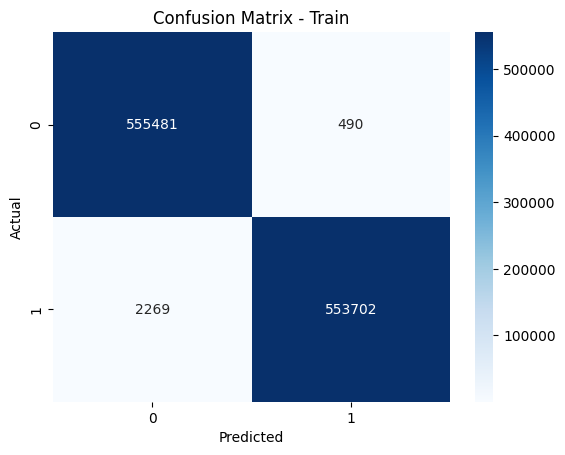

In [ ]:
plot_confusion_matrix(y_train_res, y_train_pred, 'Confusion Matrix - Train')

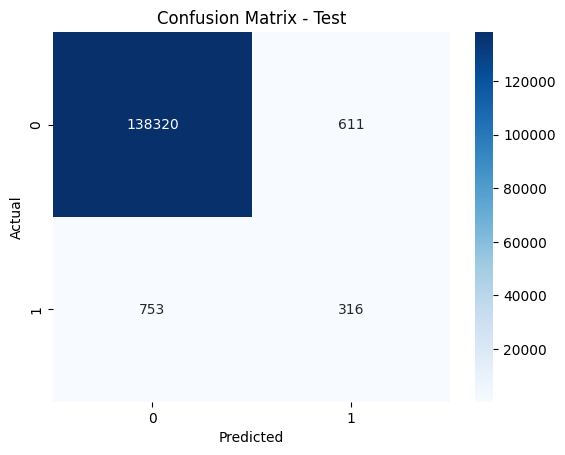

In [ ]:
plot_confusion_matrix(y_test, y_test_pred, 'Confusion Matrix - Test')

In [ ]:
# Print classification report
print("Classification Report - Train")
print(classification_report(y_train_res, y_train_pred))

Classification Report - Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    555971
           1       1.00      1.00      1.00    555971

    accuracy                           1.00   1111942
   macro avg       1.00      1.00      1.00   1111942
weighted avg       1.00      1.00      1.00   1111942



In [ ]:
print("Classification Report - Test")
print(classification_report(y_test, y_test_pred))

Classification Report - Test
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    138931
           1       0.34      0.30      0.32      1069

    accuracy                           0.99    140000
   macro avg       0.67      0.65      0.66    140000
weighted avg       0.99      0.99      0.99    140000



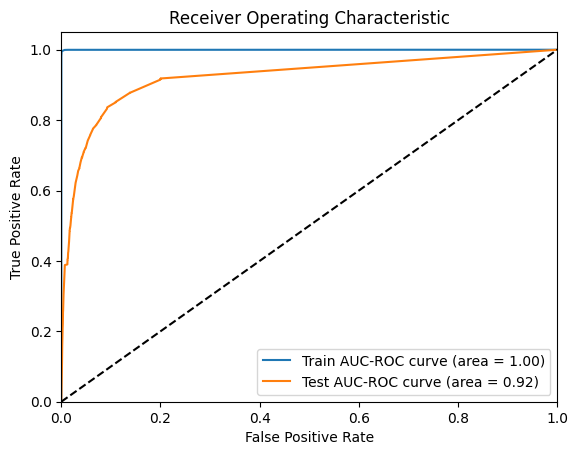

In [ ]:
# Plot AUC-ROC curve
y_train_prob = model.predict_proba(X_train_res)[:, 1]
y_test_prob = model.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train_res, y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

plt.figure()
plt.plot(fpr_train, tpr_train, label='Train AUC-ROC curve (area = {:.2f})'.format(roc_auc_score(y_train_res, y_train_prob)))
plt.plot(fpr_test, tpr_test, label='Test AUC-ROC curve (area = {:.2f})'.format(roc_auc_score(y_test, y_test_prob)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Save the model in pickle format
joblib.dump(model, 'random_forest_model.pkl')

# Save the label encoders
joblib.dump(label_encoders, 'label_encoders.pkl')

# Save the target encoder
joblib.dump(target_encoder, 'target_encoder.pkl')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']